In [1]:
import sys
import xarray as xr
import torch
import random
import numpy as np
import torchinfo
import importlib as imp
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import cartopy as ct
import cmasher as cmr

import utils
import datamaker.data_loader as data_loader
from datamaker.data_generator import ClimateData
import datamaker.regions as regions
from trainer.trainer import Trainer
from model.model import TorchModel
import model.loss as module_loss
import model.metric as module_metric
import visuals.plots as plots
from shash.shash_torch import Shash

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# TODO: Further edit the README
# TODO: Add data loading structure to template.

python version = 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:36:57) [Clang 15.0.7 ]
numpy version = 1.26.4
xarray version = 2024.1.1
pytorch version = 2.4.1.post3


In [2]:
config = utils.get_config("exp401")
seed = config["seed_list"][0]
device = utils.prepare_device(config["device"])

OBS_SSP = "ssp119"
# OBS_SSP = "ssp126"
# OBS_SSP = "ssp245"
OBS_SLICE = slice(-1, None)
LOW_QUANTILE, HIGH_QUANTILE = 1.0 / 6.0, 1.0 - 1.0 / 6.0
LOSS_THRESHOLD = -0.1
SEED_COUNT_MAX = 15

In [3]:
# Get the data
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

print("getting data ...")
data = ClimateData(
    config["datamaker"],
    expname=config["expname"],
    seed=seed,
    data_dir=config["data_dir"],
    figure_dir=config["figure_dir"],
    verbose=False,
)

trainset = data_loader.CustomData(data.d_train)
valset = data_loader.CustomData(data.d_val)
testset = data_loader.CustomData(data.d_test)

getting data ...


In [4]:
# Get the observational data

data.fetch_obs(ssp=OBS_SSP, verbose=False)
obsset = data_loader.CustomData(data.d_obs)

data_ssp = ClimateData(
    config["datamaker"],
    expname=config["expname"],
    seed=seed,
    data_dir=config["data_dir"],
    figure_dir=config["figure_dir"],
    fetch=False,
    verbose=False,
)

# loop through seeds to make the derived distribution
N = 50_000
# x = np.arange(-2, 15, 0.01)

for ssp in ("ssp245", "ssp126", "ssp119"):

    try:
        data_ssp.reset()
    except:
        pass

    data_ssp.fetch_obs(ssp=ssp, verbose=False)
    obsset_ssp = data_loader.CustomData(data_ssp.d_obs)

    Y_rv = np.zeros((data_ssp.d_obs["current_temp"].shape[0], len(config["seed_list"]), N)) * np.nan
    Y_rv_stats = []

    seed_count = 0
    for iseed, seed in enumerate(config["seed_list"]):

        if seed_count == SEED_COUNT_MAX:
            break

        # Get metrics
        model_name = utils.get_model_name(config["expname"], seed)
        try:
            df = pd.read_pickle(config["output_dir"] + model_name + "_metrics.pickle")
        except:
            continue

        if df["loss_test"][0] > LOSS_THRESHOLD:
            continue

        # Count the seed
        seed_count = seed_count + 1

        # Load the model
        model = TorchModel(
            config=config["arch"],
            target_mean=df["target_mean"][0],
            target_std=df["target_std"][0],
        )
        model = utils.load_torch_model(model, config["model_dir"] + model_name + ".pt")
        print(f"   loaded_model = {model_name}. {df["loss_test"][0] = :2.4f}")

        output = model.predict(dataset=obsset_ssp, batch_size=128, device=device)
        # print(f"{output.shape = }")

        for iyear in range(data.d_obs["current_temp"].shape[0]):
            Y_rv[iyear, iseed, :] = Shash(output[iyear][None,:]).rvs(N).numpy()

    # compute basic stats about the derived distributions
    output = np.reshape(Y_rv, (Y_rv.shape[0], Y_rv.shape[1]*Y_rv.shape[2]))
    data.d_obs["output_mean_" + ssp] = np.nanmean(output, axis=1)
    data.d_obs["output_low_" + ssp] = np.nanquantile(output, LOW_QUANTILE, axis=1)
    data.d_obs["output_med_" + ssp] = np.nanquantile(output, .50, axis=1)
    data.d_obs["output_high_" + ssp] = np.nanquantile(output, HIGH_QUANTILE, axis=1)

    print(f"{data.d_obs["output_mean_" + ssp][OBS_SLICE][0] = :2.4f}\n"
    f"{data.d_obs["output_mean_" + ssp][OBS_SLICE][0] + data.d_obs["current_temp"][OBS_SLICE][0] = :2.4f}\n"
    f"{data.d_obs["output_low_" + ssp][OBS_SLICE][0] = :2.4f}\n"
    f"{data.d_obs["output_med_" + ssp][OBS_SLICE][0] = :2.4f}\n"
    f"{data.d_obs["output_high_" + ssp][OBS_SLICE][0] = :2.4f}\n"
    )

del data_ssp

/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed314. df["loss_test"][0] = -0.2955


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed159. df["loss_test"][0] = -0.2862


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed358. df["loss_test"][0] = -0.2988


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed323. df["loss_test"][0] = -0.2040


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed264. df["loss_test"][0] = -0.1777


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed327. df["loss_test"][0] = -0.2161


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed950. df["loss_test"][0] = -0.2116


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed288. df["loss_test"][0] = -0.3073


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed716. df["loss_test"][0] = -0.2306


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed939. df["loss_test"][0] = -0.3028


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed937. df["loss_test"][0] = -0.1769


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed510. df["loss_test"][0] = -0.2455


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed582. df["loss_test"][0] = -0.2172


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed494. df["loss_test"][0] = -0.1759


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed111. df["loss_test"][0] = -0.2558
data.d_obs["output_mean_" + ssp][OBS_SLICE][0] = 2.0558
data.d_obs["output_mean_" + ssp][OBS_SLICE][0] + data.d_obs["current_temp"][OBS_SLICE][0] = 3.5958
data.d_obs["output_low_" + ssp][OBS_SLICE][0] = 1.5824
data.d_obs["output_med_" + ssp][OBS_SLICE][0] = 1.9233
data.d_obs["output_high_" + ssp][OBS_SLICE][0] = 2.5320



/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed314. df["loss_test"][0] = -0.2955


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed159. df["loss_test"][0] = -0.2862


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed358. df["loss_test"][0] = -0.2988


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed323. df["loss_test"][0] = -0.2040


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed264. df["loss_test"][0] = -0.1777


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed327. df["loss_test"][0] = -0.2161


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed950. df["loss_test"][0] = -0.2116


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed288. df["loss_test"][0] = -0.3073


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed716. df["loss_test"][0] = -0.2306


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed939. df["loss_test"][0] = -0.3028


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed937. df["loss_test"][0] = -0.1769


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed510. df["loss_test"][0] = -0.2455


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed582. df["loss_test"][0] = -0.2172


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed494. df["loss_test"][0] = -0.1759


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed111. df["loss_test"][0] = -0.2558
data.d_obs["output_mean_" + ssp][OBS_SLICE][0] = 0.9149
data.d_obs["output_mean_" + ssp][OBS_SLICE][0] + data.d_obs["current_temp"][OBS_SLICE][0] = 2.4549
data.d_obs["output_low_" + ssp][OBS_SLICE][0] = 0.7116
data.d_obs["output_med_" + ssp][OBS_SLICE][0] = 0.8902
data.d_obs["output_high_" + ssp][OBS_SLICE][0] = 1.1194

   loaded_model = exp401_seed314. df["loss_test"][0] = -0.2955


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed159. df["loss_test"][0] = -0.2862


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed358. df["loss_test"][0] = -0.2988


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed323. df["loss_test"][0] = -0.2040


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed264. df["loss_test"][0] = -0.1777


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed327. df["loss_test"][0] = -0.2161


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed950. df["loss_test"][0] = -0.2116


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed288. df["loss_test"][0] = -0.3073


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed716. df["loss_test"][0] = -0.2306


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed939. df["loss_test"][0] = -0.3028


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed937. df["loss_test"][0] = -0.1769


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed510. df["loss_test"][0] = -0.2455


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed582. df["loss_test"][0] = -0.2172


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed494. df["loss_test"][0] = -0.1759


/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2024/shash_peak_warming/utils/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename)

   loaded_model = exp401_seed111. df["loss_test"][0] = -0.2558
data.d_obs["output_mean_" + ssp][OBS_SLICE][0] = 0.6509
data.d_obs["output_mean_" + ssp][OBS_SLICE][0] + data.d_obs["current_temp"][OBS_SLICE][0] = 2.1909
data.d_obs["output_low_" + ssp][OBS_SLICE][0] = 0.4791
data.d_obs["output_med_" + ssp][OBS_SLICE][0] = 0.6392
data.d_obs["output_high_" + ssp][OBS_SLICE][0] = 0.8210



In [5]:
# torchinfo.summary(
#     model,
#     [
#         trainset.input[: config["datamaker"]["batch_size"]].shape,
#         trainset.input_unit[: config["datamaker"]["batch_size"]].shape,
#     ],
#     verbose=0,
#     col_names=("input_size", "output_size", "num_params"),
# )

# CMIP Timeseries

In [6]:
# Plotting choices
colors = {
    "ssp119": "#39a3c6",
    "ssp126": "#202e52",
    "ssp245": "#e78928",
    "ssp370": "#E4201D",
    "obs": "black",
    "obs_pred": "deeppink",
    # "obs": "deeppink",
    # "obs_pred": "black"
}

In [ ]:
plt.figure(figsize=(7, 4))

plt.axhline(y=0, color="k", linewidth=1.0)

for ssp in np.unique(data.d_train["ssp"])[::-1]:
    for gcm in np.unique(data.d_train["gcm_name"]):
        for mem in range(5):
            for d in (data.d_train, data.d_val, data.d_test):
                i = np.where(
                    (d["ssp"] == ssp) & (d["gcm_name"] == gcm) & (d["member"] == mem)
                )[0]
                plt.plot(
                    d["year"][i],
                    d["current_temp"][i],
                    "-",
                    color=colors[ssp],
                    linewidth=1.0,
                    alpha=0.2,
                )

plt.plot(100, 100, "-", label="SSP1-1.9", color=colors["ssp119"])
plt.plot(100, 100, "-", label="SSP1-2.6", color=colors["ssp126"])
plt.plot(100, 100, "-", label="SSP2-4.5", color=colors["ssp245"])
plt.legend()

plt.xlim(1975, 2101)
plt.ylim(-0.6, 5.8)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.ylabel("temperature anomaly (deg. C)")

plt.tight_layout()
plots.savefig(
    config["figure_dir"] + "release/" + config["expname"] + "_ssp_temp_timeseries",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

# Prediction Plots

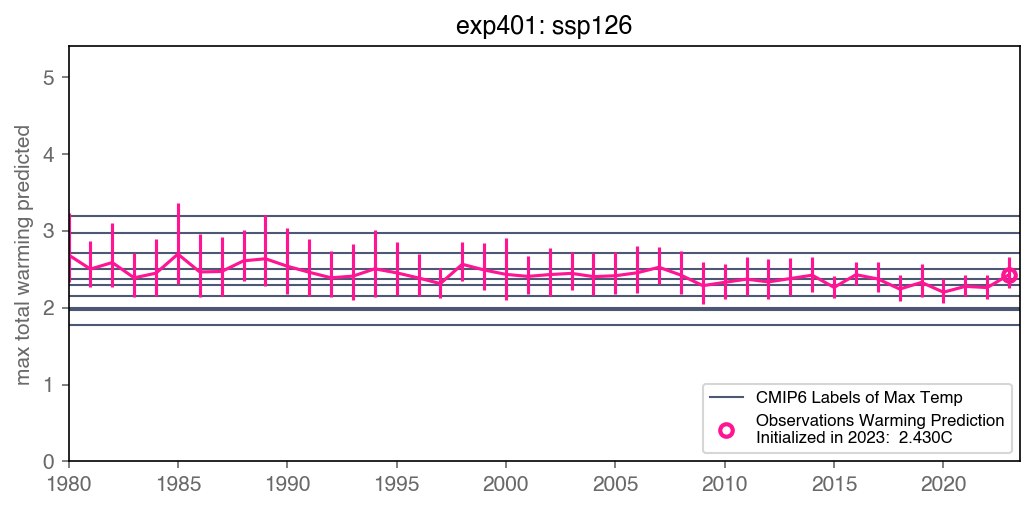

In [7]:
plt.figure(figsize=(7, 3.5))
# ------------------
plt.subplot(1, 1, 1)

# plot CMIP6 model tresholds
issp = np.where(data.d_test["ssp"] == OBS_SSP)[0]
label = f"CMIP6 Labels of Max Temp"
for max_temp in np.unique(data.d_test["max_temp"][issp]):
    plt.axhline(
        y=max_temp,
        linewidth=1.0,
        color=colors[OBS_SSP],
        alpha=0.8,
        label=label,
    )
    label = None

samples = np.where(
    (data.d_test["ssp"] == data.d_test["ssp"][0])
    & (data.d_test["year"] == config["datamaker"]["final_year_of_obs"])
)[0]
label = f"CMIP6 Predictions Initialized in {config['datamaker']['final_year_of_obs']}"

plt.errorbar(
    data.d_obs["year"],
    data.d_obs["output_med_" + OBS_SSP] + data.d_obs["current_temp"],
    np.concatenate(
        (
            data.d_obs["output_med_" + OBS_SSP]
            - data.d_obs["output_low_" + OBS_SSP][np.newaxis, :],
            (
                data.d_obs["output_high_" + OBS_SSP][np.newaxis, :]
                - data.d_obs["output_med_" + OBS_SSP]
            ),
        ),
        axis=0,
    ),
    color=colors["obs_pred"],
    label="Observations Predictions w/ 66th %tile range",
)

plt.plot(
    data.d_obs["year"][-1],
    data.d_obs["output_med_" + OBS_SSP][OBS_SLICE]
    + data.d_obs["current_temp"][OBS_SLICE],
    "o",
    markeredgecolor=colors["obs_pred"],
    markersize=6,
    markerfacecolor="none",
    markeredgewidth=2,
    label=f"Observations Warming Prediction\nInitialized in {config['datamaker']['final_year_of_obs']}: {data.d_obs['current_temp'][OBS_SLICE][0] + data.d_obs['output_med_' + OBS_SSP][OBS_SLICE][0]: 2.3f}C",
)

plt.xlim(1980, 2023.5)
plt.ylabel("max total warming predicted")
plt.title(config["expname"] + ": " + OBS_SSP)
if OBS_SSP == "ssp119":
    plt.ylim(0.0, 4.1)
else:
    plt.ylim(0.0, 5.4)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1]
plt.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    fontsize=8,
    loc="lower right",
)
# plt.legend(fontsize=8, loc="upper left")

plt.tight_layout()
plots.savefig(
    config["figure_dir"]
    + "release/"
    + config["expname"]
    + "_BEST_timeseries_predictions_"
    + OBS_SSP,
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)
plt.show()

In [ ]:
# Mean prediction using initializations from 1980-2000
x = data.d_obs["output_med_" + OBS_SSP] + data.d_obs["current_temp"]
x_low = data.d_obs["output_low_" + OBS_SSP] + data.d_obs["current_temp"]
x_high = data.d_obs["output_high_" + OBS_SSP] + data.d_obs["current_temp"]
iy = np.where((data.d_obs["year"] < 2000) & (data.d_obs["year"] >= 1980))[0]

print(f"Mean Prediction 1980-2000 = {np.mean(x[iy])}")

# ------------------
# plot predictions

plt.figure(figsize=(7, 3.5))
plt.subplot(1, 1, 1)

plt.plot(
    data.d_obs["year"],
    data.d_obs["current_temp"],
    "-",
    color=colors["obs"],
    linewidth=3,
    label="Observations",
    zorder=0,
)

iplot = np.where(data.d_obs["year"] < 2000)[0]
plt.errorbar(
    data.d_obs["year"][iplot],
    (data.d_obs["output_med_" + OBS_SSP] + data.d_obs["current_temp"])[iplot],
    np.concatenate(
        (
            (
                data.d_obs["output_med_" + OBS_SSP][iplot]
                - data.d_obs["output_low_" + OBS_SSP][np.newaxis, iplot]
            ),
            (
                data.d_obs["output_high_" + OBS_SSP][np.newaxis, iplot]
                - data.d_obs["output_med_" + OBS_SSP][iplot]
            ),
        ),
        axis=0,
    ),
    color=colors["obs_pred"],
    label="Observations Predictions w/ 66th %tile bounds",
    zorder=0,
)

plt.fill_between(
    np.arange(1850, 2110),
    np.mean(x_low[iy]),
    np.mean(x_high[iy]),
    color=colors["obs_pred"],
    alpha=0.2,
    zorder=0,
)

plt.axhline(
    y=np.mean(x[iy]),
    linestyle=":",
    color=colors["obs_pred"],
    linewidth=1.0,
    label="max temp prediction for " + config["datamaker"]["obs_source"],
    zorder=0,
)

plt.xlim(1980, 2023.5)
plt.ylabel("temperature anomaly (deg. C)")
plt.title(
    config["expname"] + ": " + OBS_SSP + " for " + config["datamaker"]["obs_source"]
)
plt.ylim(0.0, 4.1)

plt.legend(fontsize=8, loc="upper left")

plt.tight_layout()
plots.savefig(
    config["figure_dir"]
    + "release/"
    + config["expname"]
    + "_"
    + config["datamaker"]["obs_source"]
    + "_historical_2023_"
    + OBS_SSP,
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)
plt.show()

# raise ValueError

In [10]:
# raise ValueError

# Storyline Plots

In [6]:
import copy

config_base = copy.deepcopy(config)
config_base["datamaker"]["gcmsub"] = ["single_member"]
config_base["datamaker"]["n_train_val_test"] = [[1, 0, 0]]

data_base = ClimateData(
    config_base["datamaker"],
    expname=config_base["expname"],
    seed=seed,
    data_dir=config_base["data_dir"],
    figure_dir=config_base["figure_dir"],
    verbose=False,
)

In [7]:
from datamaker.sample_vault import SampleDict

unique_members_list = []

for db in (data_base.d_train,):
    isamples = np.where(
        (
            (
                db["max_temp"]
                > data.d_obs["output_low_" + OBS_SSP][OBS_SLICE]
                + data.d_obs["current_temp"][OBS_SLICE]
            )
            & (
                db["max_temp"]
                < data.d_obs["output_high_" + OBS_SSP][OBS_SLICE]
                + data.d_obs["current_temp"][OBS_SLICE]
                + 0.01
            )
        )
        & (db["ssp"] == OBS_SSP)
    )[0]
    d = db.subsample(isamples, use_copy=True)

    unique_members = np.unique(
        list(
            zip(
                d["ssp"],
                d["gcm_name"],
                d["member"],
                d["year_reached"],
                d["max_temp"],
            )
        ),
        axis=0,
    )
    unique_members_list.extend(unique_members.tolist())
    print(unique_members)

[['ssp119' 'ssp119_IPSL-CM6A-LR_r1i1p1f1' '0' '2037' '2.366791729572981']]


In [13]:
# raise ValueError()

### Plot timeseries of storylines

In [ ]:
# -------------------------------------------
# plot the closest storylines

plt.plot(
    data.d_obs["year"],
    data.d_obs["current_temp"],
    "-",
    color=colors["obs"],
    linewidth=3,
    zorder=1000,
    label="BEST",
)

for d in (data_base.d_train,):
    for ssp in (OBS_SSP,):
        for gcm in np.unique(d["gcm_name"]):
            for m in np.unique(d["member"]):
                j = np.where(
                    (d["gcm_name"] == gcm) & (d["member"] == m) & (d["ssp"] == ssp)
                )[0]
                plt.plot(
                    d["year"][j],
                    d["current_temp"][j],
                    linewidth=0.25,
                    color=colors[OBS_SSP],
                    alpha=0.25,
                )

for d in (data_base.d_train,):
    for mem in range(np.shape(unique_members_list)[0]):
        i = np.where(
            (d["gcm_name"] == unique_members_list[mem][1])
            & (d["member"] == int(unique_members_list[mem][2]))
            & (d["ssp"] == unique_members_list[mem][0])
        )[0]

        plt.plot(
            d["year"][i],
            d["current_temp"][i],
            linewidth=1.0,
            color=colors[OBS_SSP],
            label=d["ssp"][i[0]]
            + " "
            + d["gcm_name"][i[0]]
            + ", #"
            + str(d["member"][i[0]]),
        )

    for story in unique_members_list:
        k = np.where(d["current_temp"] == float(story[-1]))[0]
        print(d["current_temp"][k])
        plt.plot(
            d["year"][k],
            d["current_temp"][k],
            "o",
            markeredgecolor=colors["obs_pred"],
            markersize=8,
            linewidth=3,
            alpha=1.0,
            markerfacecolor="none",
        )

plt.fill_between(
    np.arange(1850, 2110),
    data.d_obs["current_temp"][OBS_SLICE]
    + data.d_obs["output_low_" + OBS_SSP][OBS_SLICE],
    data.d_obs["current_temp"][OBS_SLICE]
    + data.d_obs["output_high_" + OBS_SSP][OBS_SLICE],
    color=colors["obs_pred"],
    alpha=0.2,
    zorder=100,
)
plt.axhline(
    y=data.d_obs["output_med_" + OBS_SSP][OBS_SLICE]
    + data.d_obs["current_temp"][OBS_SLICE],
    linestyle=":",
    color=colors["obs_pred"],
    linewidth=1.0,
    label="max temp prediction for BEST",
)

plt.gca().spines[["right", "top"]].set_visible(False)
plt.legend(fontsize=5)
plt.ylabel("temperature anomaly (deg. C)")
plt.xlim(1975, 2100)
plt.title(config["expname"] + ": " + OBS_SSP)

plt.tight_layout()
plots.savefig(
    config["figure_dir"]
    + "release/"
    + config["expname"]
    + "_storyline_timeseries_"
    + OBS_SSP,
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

### Plot storyline maps

In [ ]:
np.seterr(invalid="ignore")

EXTREMES_DATA_DIRECTORY = "../../2022/netzero_perception/data/"
map_proj = ct.crs.EqualEarth(central_longitude=0.0)
cmap = "RdBu_r"
vscale = 5

db = data_base.d_train
dict_extreme = {}
for imem in range(len(unique_members_list)):
    member = unique_members_list[imem]
    gcm_name = member[1][member[1].find(member[0] + "_") + 7 : member[1].find("_r")]

    isamples = np.where(
        (db["gcm_name"] == unique_members[imem, 1])
        & (db["member"] == int(unique_members[imem, 2]))
        # & (d["year"] == int(unique_members[imem, 3]))
        & (db["current_temp"] > data.d_obs["output_low_" + OBS_SSP][OBS_SLICE] + data.d_obs["current_temp"][OBS_SLICE])
        & (db["current_temp"] < data.d_obs["output_high_" + OBS_SSP][OBS_SLICE] + data.d_obs["current_temp"][OBS_SLICE])
    )[0]

    try:
        f = (
            EXTREMES_DATA_DIRECTORY
            + f"pr_day_historical_{gcm_name}_r1-5_ncecat_yearmax_2pt5degree.nc"
        )
        da = xr.load_dataarray(f).mean(axis=0)
    except:
        dict_extreme = {}
        break

    baseline_mean = da.sel(
        time=slice(
            str(config["datamaker"]["baseline_yr_bounds"][0]),
            str(config["datamaker"]["baseline_yr_bounds"][1]),
        )
    ).mean("time")

    f = (
        EXTREMES_DATA_DIRECTORY
        + f"pr_day_{member[0]}_{gcm_name}_r1-5_ncecat_yearmax_2pt5degree.nc"
    )
    print(f)
    da = xr.load_dataarray(f)[int(member[2]), ...]
    _, iyears, _ = np.intersect1d(da["time.year"], db["year"][isamples], return_indices=True)
    da = 100 * (da[iyears, :, :] - baseline_mean) / baseline_mean

    # change units
    # da = da * 86400.  # convert from kg/m2/2 to mm/day

    if not bool(dict_extreme):
        dict_extreme["x"] = da.values[np.newaxis, :, :]
    else:
        dict_extreme["x"] = np.append(
            dict_extreme["x"], da.values[np.newaxis, :, :], axis=0
        )
try:
    print(f"{dict_extreme['x'].shape = }")
except:
    dict_extreme["x"] = (
        np.zeros((1, data_base.lat.shape[0], data_base.lon.shape[0])) * np.nan
    )

# ---------------
# PLOT THE RESULT
if len(isamples) > 0:
    fig = plt.figure(figsize=(13, 4), dpi=150)

    ax = fig.add_subplot(1, 2, 1, projection=map_proj)
    cb, _ = plots.drawOnGlobe(
        ax,
        map_proj,
        data=db["x"][isamples].mean(axis=0).squeeze(),
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=-vscale,
        vmax=vscale,
        cbarBool=True,
        extent="both",
    )
    cb.set_label("degrees above baseline (C)")
    plt.title(
        f"{config["expname"]}\nN = {len(unique_members_list)} members, {len(isamples)} years,  closest to {(data.d_obs["output_med_" + OBS_SSP][OBS_SLICE] + data.d_obs["current_temp"][OBS_SLICE]).round(2)}C"
    )

    # ---------------------
    ax = fig.add_subplot(1, 2, 2, projection=map_proj)
    cb, _ = plots.drawOnGlobe(
        ax,
        map_proj,
        data=dict_extreme["x"].mean(axis=(0,1)).squeeze(),
        lats=data_base.lat,
        lons=data_base.lon,
        fastBool=True,
        cmap="BrBG",
        vmin=-100,
        vmax=100,
        cbarBool=True,
        extent="both",
    )
    cb.set_label("precipitation extremes (% above baseline mean)")
    plt.title(
        f"{config["expname"]}\nN = {len(unique_members)} members, {dict_extreme["x"].shape[1]} years, closest to {(data.d_obs["output_med_" + OBS_SSP][OBS_SLICE] + data.d_obs["current_temp"][OBS_SLICE]).round(2)}C"
    )

    # ---------------------
    plt.tight_layout()
    plots.savefig(
    config["figure_dir"]
    + "release/"
    + config["expname"]
    + "_storyline_maps_"
    + OBS_SSP,
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"])

    plt.show()

In [16]:
# raise ValueError

### Regional scatter plots of peak warming

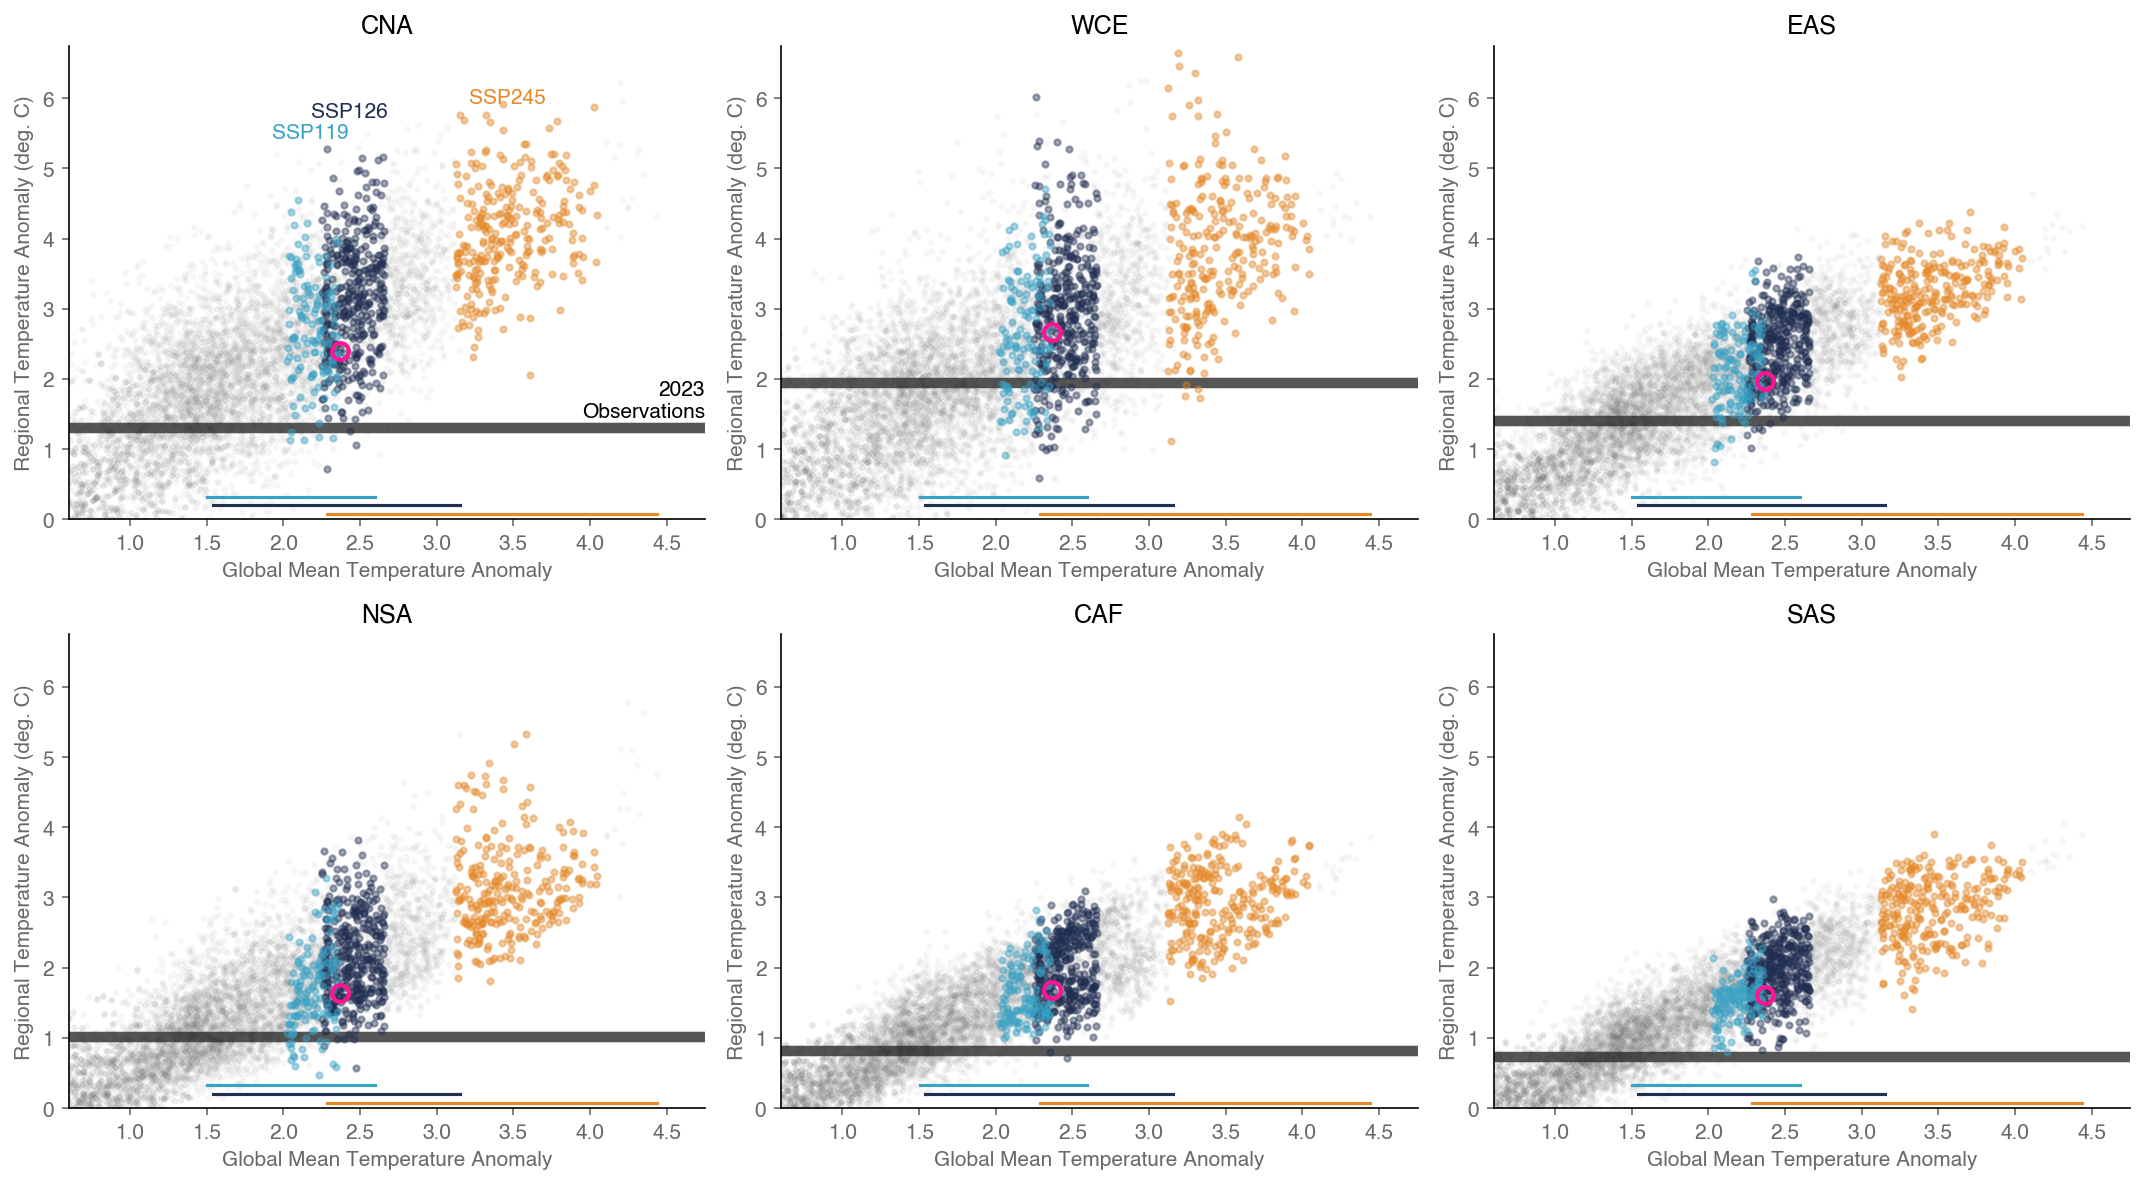

In [22]:
plt.figure(figsize=(18 * 0.8, 10 * 0.8))
for ireg, reg in enumerate(("CNA", "WCE", "EAS", "NSA", "CAF", "SAS")):

    plt.subplot(2, 3, ireg + 1)

    for issp, ssp in enumerate(config["datamaker"]["ssp_list"][::-1]):

        for d in (data_base.d_train,):

            j = np.where(
                (
                    (
                        db["current_temp"]
                        > data.d_obs["output_low_" + ssp][OBS_SLICE]
                        + data.d_obs["current_temp"][OBS_SLICE]
                    )
                    & (
                        db["current_temp"]
                        < data.d_obs["output_high_" + ssp][OBS_SLICE]
                        + data.d_obs["current_temp"][OBS_SLICE]
                    )
                )
                & (d["ssp"] == ssp)
            )[0]

            k = np.where((d["ssp"] == ssp))[0]

            d_reg = regions.extract_region(
                d["x"][:, :, :, 0],
                region=reg,
                dir=config["data_dir"],
                lat=data_base.lat,
                lon=data_base.lon,
            )
            d_reg = regions.compute_global_mean(
                d_reg,
                lat=data_base.lat,
                lon=data_base.lon,
            ).to_numpy()

            d_reg_obs = regions.extract_region(
                data.d_obs["x"][:, :, :, 0],
                region=reg,
                dir=config["data_dir"],
                lat=data.lat,
                lon=data.lon,
            )
            d_reg_obs = regions.compute_global_mean(
                d_reg_obs,
                lat=data.lat,
                lon=data.lon,
            ).to_numpy()

            # MAKE THE PLOT
            plt.plot(d["current_temp"][:], d_reg[:], ".", color="gray", alpha=0.025, zorder=0, markeredgewidth=0)
            # plt.plot(d["current_temp"][k], d_reg[k], ".", color=colors[ssp], alpha=0.1, zorder=0, markeredgewidth=0)
            plt.plot(d["current_temp"][j], d_reg[j], ".", color=colors[ssp], alpha=0.4)

            # PLOT STORYLINES
            if ssp == "ssp119":
                for story in unique_members_list:
                    k = np.where(d["current_temp"] == float(story[-1]))[0]
                    plt.plot(
                        d["current_temp"][k],
                        d_reg[k],
                        "o",
                        markeredgecolor=colors["obs_pred"],
                        markersize=8,
                        linewidth=3,
                        markeredgewidth=2,
                        alpha=1.0,
                        markerfacecolor="none",
                    )
            # PLOT THE SPREADS of GMT MAX TEMPS
            i = np.where(d["ssp"] == ssp)
            cmip_min = np.unique(d["max_temp"][i]).min()
            cmip_max = np.unique(d["max_temp"][i]).max()
            plt.plot(
                (cmip_min, cmip_max),
                np.zeros(2) + issp * 0.125 + 0.075,
                "-",
                color=colors[ssp],
            )

        # EXTRA BITS
        legentry = None
        if ssp == "ssp119":
            legentry = "2023 Observations"
        else:
            legentry = None
        plt.plot(
            (0, 5.0),
            (d_reg_obs[-1], d_reg_obs[-1]),
            color=colors["obs"],
            linewidth=5,
            alpha=0.3,
            zorder=0,
            label=legentry,
        )

        if ireg == 0:
            if ssp == "ssp119":
                y_val = 5.65
            elif ssp == "ssp126":
                y_val = 5.95
            else:
                y_val = 6.15

            plt.text(
                data.d_obs["output_med_" + ssp][OBS_SLICE]
                + data.d_obs["current_temp"][OBS_SLICE],
                y_val,
                ssp.upper(),
                color=colors[ssp],
                ha="center",
                va="top",
            )

    if ireg == 0:
        # plt.legend(loc="lower right", frameon=False)
        plt.text(
            4.75,
            d_reg_obs[-1] + 0.1,
            "2023\nObservations",
            ha="right",
            va="bottom",
            color=colors["obs"],
        )

    plt.ylabel("Regional Temperature Anomaly (deg. C)")
    plt.xlabel("Global Mean Temperature Anomaly")
    plt.xlim(0.6, 4.75)
    plt.ylim(0.0, 6.75)

    plt.title(reg)
    plt.gca().spines[["right", "top"]].set_visible(False)

plt.tight_layout()
plots.savefig(
    config["figure_dir"] + "release/" + model_name + "_regional_anomaly_scatter",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)
plt.show()

In [18]:
# raise ValueError

# Matthews and Wynes

In [ ]:
# MAKE THE COLORMAP
# cmap = cmr.get_sub_cmap("twilight_r", 0.05, 0.95)

cm_mid = (0.4, 0.6)
n = (75, 75)

c0 = cmr.take_cmap_colors(cmr.get_sub_cmap("twilight_r", 0.05, cm_mid[0]), N=n[0])
c1 = cmr.take_cmap_colors(cmr.get_sub_cmap("twilight_r", cm_mid[0], cm_mid[1]), N=n[1])
c2 = cmr.take_cmap_colors(cmr.get_sub_cmap("twilight_r", cm_mid[1], 0.95), N=n[0])
c = np.vstack((c0, c1))
c = np.vstack((c, c2))
cmap = mcolors.ListedColormap(c)
cmap

In [ ]:
from datamaker.sample_vault import SampleDict
import scipy

i = np.where((data.d_train["year"] == data.d_obs["year"][OBS_SLICE]))[0]
max_emissions_left = data.d_train["emissions_left"][i].max()
emissions_list = np.arange(0, max_emissions_left * 1.01, 0.005)

mw_dict = SampleDict()
mw_dict["x"] = np.repeat(data.d_obs["x"][OBS_SLICE], len(emissions_list), axis=0)
mw_dict["emissions_left"] = emissions_list
mw_dict["y"] = np.zeros(emissions_list.shape)
mwset = data_loader.CustomData(mw_dict)

# -------------------------------------------------------
N = 1_000
seed_list = config["seed_list"]
Y_rv = np.ones((len(seed_list), len(emissions_list), N)) * np.nan

seed_count = 0
for i_seed, seed in enumerate(seed_list):

    if seed_count == SEED_COUNT_MAX:
        break

    # Get metrics
    model_name = utils.get_model_name(config["expname"], seed)
    try:
        df = pd.read_pickle(config["output_dir"] + model_name + "_metrics.pickle")
    except:
        continue

    if df["loss_test"][0] > LOSS_THRESHOLD:
        continue

    # Count the seed
    seed_count = seed_count + 1

    # Load the model
    model_dw = TorchModel(
        config=config["arch"],
        target_mean=df["target_mean"][0],
        target_std=df["target_std"][0],
    )
    model_dw = utils.load_torch_model(model_dw, config["model_dir"] + model_name + ".pt")
    print(f"   loaded_model = {model_name}. {df["loss_test"][0] = :2.4f}")

    # Make predictions for obs
    output_mw = model.predict(dataset=mwset, batch_size=128, device=device)
    print(f"{output_mw.shape = }")

    for i_emis in range(output_mw.shape[0]):
        Y_rv[i_seed, i_emis, :] = Shash(output_mw[i_emis, :][None,:]).rvs(N).numpy()


# loop through temps and compute CDF
print(f"{np.shape(Y_rv) = }")
print("\ncomputing CDFs...")
temp_list = np.arange(-1., 5, 0.01)
prob_temp = np.zeros((temp_list.shape[0], output_mw.shape[0]))
for it, temp_inc in enumerate(temp_list):
    for i_emis in range(output_mw.shape[0]):
        y = Y_rv[:, i_emis, :].flatten()
        prob_temp[it, i_emis] = scipy.stats.percentileofscore(y, temp_inc, nan_policy="omit") / 100.

print(f"{prob_temp.shape = }")

In [ ]:
# Make the Matthews & Wynes Heatmap

plt.pcolormesh(
    emissions_list * 1000,
    temp_list + data.d_obs["current_temp"][OBS_SLICE],
    100 * prob_temp,
    cmap=cmap,
)

cb = plt.colorbar(label="Chance of staying below temperature (%)")
cb.set_ticks((5, 33, 50, 67, 95))
cb.set_ticklabels(("5%", "33", "50", "67", "95%"))
plt.clim(0, 100)

plt.xlabel("Remaining Emissions (Gt CO2 from 2024 onwards)")
plt.ylabel("Maximum temperature increase from pre-industrial (deg. C)")

# plot SSP lines
for ssp in config["datamaker"]["ssp_list"]:
    i = np.where(
        (data.d_train["ssp"] == ssp)
        & (data.d_train["year"] == data.d_obs["year"][OBS_SLICE])
    )[0]

    plt.axvline(x=data.d_train["emissions_left"][i[0]] * 1000, linestyle=":", color="w")
    plt.text(
        x=data.d_train["emissions_left"][i[0]] * 1000,
        y=1.5,
        s=ssp.upper(),
        ha="right",
        va="bottom",
        rotation="vertical",
        color="white",
        fontsize=13,
        weight="bold",
    )


plt.ylim(1.3, 3.9)
plt.xlim(0, None)
plt.title(config["expname"])

plots.savefig(
    config["figure_dir"] + "release/" + config["expname"] + "_matthews_wynes_heatmap",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)
plt.show()

In [ ]:
from scipy import stats

N = 1_000_000
x = np.arange(-1, 6, 0.01)

data_plot = ClimateData(
    config["datamaker"],
    expname=config["expname"],
    seed=seed,
    data_dir=config["data_dir"],
    figure_dir=config["figure_dir"],
    fetch=False,
    verbose=False,
)

for issp, ssp in enumerate(config["datamaker"]["ssp_list"]):
    print("SSP = " + ssp)

    Y_rv = []
    Y_rv_stats = []
    seed_count = 0

    for seed in config["seed_list"]:

        if seed_count == SEED_COUNT_MAX:
            break

        # Get metrics
        model_name = utils.get_model_name(config["expname"], seed)
        try:
            df = pd.read_pickle(config["output_dir"] + model_name + "_metrics.pickle")
        except:
            continue

        if df["loss_test"][0] > LOSS_THRESHOLD:
            continue

        # Count the seed
        seed_count = seed_count + 1

        # Load the model
        model = TorchModel(
            config=config["arch"],
            target_mean=df["target_mean"][0],
            target_std=df["target_std"][0],
        )
        model = utils.load_torch_model(model, config["model_dir"] + model_name + ".pt")
        # print(f"   loaded_model = {model_name}")

        try:
            data_plot.d_obs.reset()
        except:
            pass

        data_plot.fetch_obs(ssp=ssp, verbose=False)

        # Make predictions for obs
        output = model.predict(
            dataset=data_loader.CustomData(data_plot.d_obs),
            batch_size=128,
            device=device,
        )
        y = Shash(output).prob(x).numpy()
        Y_rv.extend(
            data.d_obs["current_temp"][OBS_SLICE]
            + Shash(output[OBS_SLICE]).rvs(N).numpy()
        )
        Y_rv_stats.append(
            [
                Shash(output[OBS_SLICE]).mean().numpy(),
                Shash(output[OBS_SLICE]).var().numpy(),
            ]
        )

        # Make the plot
        # plt.plot(
        #     data.d_obs["current_temp"][OBS_SLICE] + x,
        #     y[:, OBS_SLICE],
        #     "-",
        #     linewidth=0.75,
        #     color=colors[ssp],
        #     alpha=0.5,
        # )

        if seed == 314:
            alpha = 0.35
            label = ssp.upper()
            zorder = 1
            linewidth = 1.5
        else:
            # continue
            alpha = 0.35
            label = None
            zorder = 1
            linewidth = 1.5

    Y_rv = np.asarray(Y_rv)
    Y_rv_stats = np.asarray(Y_rv_stats)
    plt.hist(
        Y_rv,
        np.arange(0, 10, 0.01),
        color=colors[ssp],
        alpha=0.65,
        density=True,
        zorder=100 - issp,
        label=ssp.upper(),
    )

    # PRINT STATS FOR PAPER TABLE
    # print(f"    {Y_rv.mean() = :2.4f}, {Y_rv.std() = :2.4f}, {Y_rv.var() = :2.4f}")
    # print(f"    {np.var(Y_rv_stats[:,0]) + np.mean(Y_rv_stats[:,1]) = :2.4f}")
    for quantile in (0.01, 0.1, 0.33, 0.5, 0.67, 0.90, 0.99):
        print(f"   {int(quantile*100)}% = {np.quantile(Y_rv, quantile) :2.4f}")
    print(
        f"   {Y_rv.min() = :2.4f}, {np.mean(Y_rv) = :2.4f}, {Y_rv.max() = :2.4f}"
    )


# raise ValueError
plt.legend()
# plt.ylim(0.01, 2.9)
plt.ylabel("probability")

plt.xticks(np.arange(0.5, 8.5, 0.5), np.arange(0.5, 8.5, 0.5).tolist())
plt.xlabel("Maximum temperature increase from pre-industrial (deg. C)")
plt.xlim(0, 7.0)

plt.title("Cross-sections: " + config["expname"])

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plots.savefig(
    config["figure_dir"] + "release/" + config["expname"] + "_cross_section",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

In [ ]:
# SUPPLEMENTAL FIGURE

from scipy import stats

N = 1_000_000
x = np.arange(-1, 6, 0.01)

data_plot = ClimateData(
    config["datamaker"],
    expname=config["expname"],
    seed=seed,
    data_dir=config["data_dir"],
    figure_dir=config["figure_dir"],
    fetch=False,
    verbose=False,
)

for issp, ssp in enumerate(config["datamaker"]["ssp_list"]):
    print("SSP = " + ssp)

    Y_rv = []
    Y_rv_stats = []
    seed_count = 0

    for seed in config["seed_list"]:

        if seed_count == SEED_COUNT_MAX:
            break

        # Get metrics
        model_name = utils.get_model_name(config["expname"], seed)
        try:
            df = pd.read_pickle(config["output_dir"] + model_name + "_metrics.pickle")
        except:
            continue

        if df["loss_test"][0] > LOSS_THRESHOLD:
            continue

        # Count the seed
        seed_count = seed_count + 1

        # Load the model
        model = TorchModel(
            config=config["arch"],
            target_mean=df["target_mean"][0],
            target_std=df["target_std"][0],
        )
        model = utils.load_torch_model(model, config["model_dir"] + model_name + ".pt")
        print(f"   loaded_model = {model_name}")

        try:
            data_plot.d_obs.reset()
        except:
            pass

        data_plot.fetch_obs(ssp=ssp, verbose=False)

        # Make predictions for obs
        output = model.predict(
            dataset=data_loader.CustomData(data_plot.d_obs),
            batch_size=128,
            device=device,
        )
        y = Shash(output).prob(x).numpy()
        Y_rv.extend(
            data.d_obs["current_temp"][OBS_SLICE]
            + Shash(output[OBS_SLICE]).rvs(N).numpy()
        )
        Y_rv_stats.append(
            [
                Shash(output[OBS_SLICE]).mean().numpy(),
                Shash(output[OBS_SLICE]).var().numpy(),
            ]
        )

        # Make the plot
        plt.plot(
            data.d_obs["current_temp"][OBS_SLICE] + x,
            y[:, OBS_SLICE],
            "-",
            linewidth=0.75,
            color=colors[ssp],
            alpha=0.5,
        )

        if seed == 314:
            alpha = 0.35
            label = ssp.upper()
            zorder = 100
            linewidth = 1.5
        else:
            # continue
            alpha = 0.35
            label = None
            zorder = 100
            linewidth = 1.5

    Y_rv = np.asarray(Y_rv)
    Y_rv_stats = np.asarray(Y_rv_stats)
    plt.hist(
        Y_rv,
        np.arange(0, 10, 0.01),
        color=colors[ssp],
        alpha=0.25,
        density=True,
        zorder=100 - issp,
        label=ssp.upper(),
    )

# raise ValueError
plt.legend()
# plt.ylim(0.01, 2.9)
plt.ylabel("probability")

plt.xticks(np.arange(0.5, 8.5, 0.5), np.arange(0.5, 8.5, 0.5).tolist())
plt.xlabel("Maximum temperature increase from pre-industrial (deg. C)")
plt.xlim(0, 7.0)

plt.title("Cross-sections: " + config["expname"])

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plots.savefig(
    config["figure_dir"]
    + "release/"
    + config["expname"]
    + "_cross_section_singleshash",
    fig_format=(".png", ".pdf"),
    dpi=config["fig_dpi"],
)

plt.show()

# XAI

In [ ]:
raise ValueError

In [ ]:
from captum.attr import IntegratedGradients

input_x = np.moveaxis(data.d_obs["x"], -1, 1)[-10:]
input_unit = np.asarray(data.d_obs["emissions_left"], dtype=input_x.dtype)[-10:]

_ = model.to("cpu")
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(
    (torch.tensor(input_x).to("cpu"), torch.tensor(input_unit).to("cpu")),
    (torch.tensor(input_x * 0).to("cpu"), torch.tensor(input_unit).to("cpu")),
    target=0,
    return_convergence_delta=True,
)
print("Convergence Delta:", delta)
print("Attributions for input_unit", attributions[1])

# MAKE THE PLOT
xplot = attributions[0][:, 0, :, :].mean(axis=0) * 300

map_proj = ct.crs.EqualEarth(central_longitude=0.0)
fig = plt.figure(figsize=(6.5, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=xplot,
    lats=data_base.lat,
    lons=data_base.lon,
    fastBool=True,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    cbarBool=True,
    extent="both",
)
plt.title("IntegratedGradients: " + model_name)
plt.show()

In [ ]:
from captum.attr import InputXGradient
import cmasher as cmr

TARGET = 0
YRSLICE = slice(-40, None)
cmap = "cmr.fusion_r"

input_x_gradient = InputXGradient(model)

input_x = np.moveaxis(data.d_obs["x"], -1, 1)[YRSLICE]
input_unit = np.asarray(data.d_obs["emissions_left"], dtype=input_x.dtype)[YRSLICE]

attributions = input_x_gradient.attribute(
    (torch.tensor(input_x).to("cpu"), torch.tensor(input_unit).to("cpu")), target=TARGET
)

# MAKE THE PLOT
xplot = attributions[0][:, 0, :, :].mean(axis=0).detach().numpy() * 300

map_proj = ct.crs.EqualEarth(central_longitude=0.0)
fig = plt.figure(figsize=(6.5, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=xplot,
    lats=data_base.lat,
    lons=data_base.lon,
    fastBool=True,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    cbarBool=True,
    extent="both",
)
plt.title(" InputXGradient: for " + str(TARGET) + ", " + model_name)
plt.show()
# cb.set_label("precipitation extremes (% above baseline mean)")

In [ ]:
plt.figure(figsize=(8, 4))
plt.title(
    "InputXGradient for Target="
    + str(TARGET)
    + "\nfor Emissions Left As a Function of Year"
)
plt.plot(
    data.d_obs["year"][YRSLICE],
    attributions[0][:, 0, :, :].sum(axis=(1, 2)).detach().numpy()
    / data.d_obs["output_mean"][YRSLICE],
    color=colors["obs"],
)
plt.plot(
    data.d_obs["year"][YRSLICE],
    attributions[1].detach().numpy() / data.d_obs["output_mean"][YRSLICE],
    color=colors["obs"],
    linestyle="--",
)
plt.show()

In [ ]:
from captum.attr import Saliency

saliency = Saliency(model)

input_x = np.moveaxis(data.d_obs["x"], -1, 1)[-20:]
input_unit = np.asarray(data.d_obs["emissions_left"], dtype=input_x.dtype)[-20:]

sensitivities = saliency.attribute(
    (torch.tensor(input_x).to("cpu"), torch.tensor(input_unit).to("cpu")),
    target=0,
    abs=False,
)

# MAKE THE PLOT
xplot = sensitivities[0][:, 0, :, :].mean(axis=0) * 300

map_proj = ct.crs.EqualEarth(central_longitude=0.0)
fig = plt.figure(figsize=(6.5, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=xplot,
    lats=data_base.lat,
    lons=data_base.lon,
    fastBool=True,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    cbarBool=True,
    extent="both",
)

plt.title("Saliency: " + model_name)
plt.show()

In [ ]:
# from captum.attr import ShapleyValueSampling

# input_x = np.moveaxis(data.d_obs["x"], -1, 1)
# input_unit = np.asarray(data.d_obs["emissions_left"], dtype=input_x.dtype)

# _ = model.to(device)
# svs = ShapleyValueSampling(model)
# attr = svs.attribute((torch.tensor(input_x).to(device), torch.tensor(input_unit).to(device)), target=0, n_samples=1)